# Import Software Packages

In [1]:
import os  # Interact with the operating system.
import sys  # Read system parameters.
import warnings  # Suppress warnings
from urllib.parse import urlparse  # Parse URL and extract path component

warnings.filterwarnings("ignore")
import jupyterlab
import matplotlib as mpl  # Create 2D charts.
import matplotlib.pyplot as plt
import numpy as np  # Work with multi-dimensional arrays and matrices.
import pandas as pd  # Manipulate and analyze data.
import scipy
import seaborn as sb  # Perform data visualization.
import sklearn  # Perform data mining and analysis.
from scipy.io import arff
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.svm import SVC

# Print summary
print("Libraries used in this project:")
print("- Python {}".format(sys.version))
print("- NumPy {}".format(np.__version__))
print("- pandas {}".format(pd.__version__))
print("- Matplotlib {}".format(mpl.__version__))
print("- Scipy {}".format(scipy.__version__))
print("- Seaborn {}".format(sb.__version__))
print("- Jupyter Lab {}".format(jupyterlab.__version__))
print("- scikit-learn {}\n".format(sklearn.__version__))

Libraries used in this project:
- Python 3.8.18 | packaged by conda-forge | (default, Dec 23 2023, 17:23:49) 
[Clang 15.0.7 ]
- NumPy 1.24.3
- pandas 2.0.3
- Matplotlib 3.7.2
- Scipy 1.10.1
- Seaborn 0.13.2
- Jupyter Lab 4.2.5
- scikit-learn 1.3.2



# Load the Dataset

In [2]:
URL = "./data/bone-marrow.arff"
data = arff.loadarff(URL)
filename = os.path.basename(URL)

df = pd.DataFrame(data[0])
df.drop(columns=["Disease"], inplace=True)
parsed_url = urlparse(URL)

print(f"Loaded {len(df)} census records from {filename}.")

Loaded 187 census records from bone-marrow.arff.


## Convert All Columns to Numeric

This process will handle numerical and categorical columns in distinct ways considering that the objective is to create a classification pipeline aimed at predicting survival status.  To start, the code will establish separate lists for each type of column. It's important to highlight that the imported data is entirely numeric; for instance, binary columns such as donor_age_below_35 are represented as numerical values (0 and 1). Likewise, categorical columns like donor_ABO, which have four categories, are encoded as -1, 0, 1, and 2. Therefore, simply relying on identifying columns based on numeric or object types to create these lists is not feasible.

To change all columns to a numeric format, make sure to handle any errors by converting them into null values.

In [3]:
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors="coerce")

## Convert Binary Columns to 0 or 1
This step ensures that binary columns are represented using the values 0 and 1.

In [4]:
# Make sure binary columns are encoded as 0 and 1
for column in df.columns[df.nunique() == 2]:
    df[column] = (df[column] == 1) * 1.0

## Examine Sample Data

In [5]:
df.head()

,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,extcGvHD,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_time,survival_status
0,1.0,1.0,22.830137,0.0,1.0,0.0,1,1.0,1.0,0.0,...,1.0,7.20,1.338760,5.38,35.0,19.0,51.0,32.0,999.0,0.0
1,1.0,0.0,23.342466,0.0,1.0,0.0,-1,-1.0,1.0,0.0,...,1.0,4.50,11.078295,0.41,20.6,16.0,37.0,1000000.0,163.0,1.0
2,1.0,0.0,26.394521,0.0,1.0,0.0,-1,-1.0,1.0,0.0,...,1.0,7.94,19.013230,0.42,23.4,23.0,20.0,1000000.0,435.0,1.0
3,0.0,0.0,39.684932,1.0,1.0,0.0,1,2.0,1.0,1.0,...,0.0,4.25,29.481647,0.14,50.0,23.0,29.0,19.0,53.0,1.0
4,0.0,1.0,33.358904,0.0,0.0,0.0,1,2.0,0.0,1.0,...,1.0,51.85,3.972255,13.05,9.0,14.0,14.0,1000000.0,2043.0,0.0


## Examine 'survival_status' Class Counts

Alive 0.0: 102 

Dead 1.0: 85 



<Axes: title={'center': 'survival_status: Alive(0.0) | Dead(1.0) '}, xlabel='survival_status', ylabel='Count'>

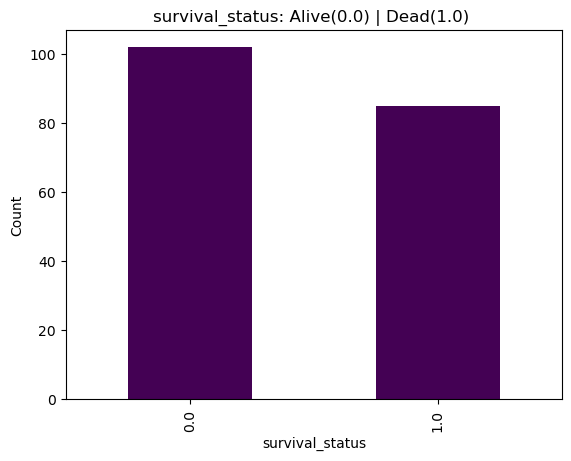

In [6]:
survival_counts = df["survival_status"].value_counts()

print("Alive 0.0:", survival_counts[0], "\n")
print("Dead 1.0:", survival_counts[1], "\n")

survival_counts.plot(
    kind="bar",
    title="survival_status: Alive(0.0) | Dead(1.0) ",
    grid=False,
    colormap="viridis",
    ylabel="Count",
)

## Examine Unique Column Values

In [7]:
df.nunique()

Recipientgender           2
Stemcellsource            2
Donorage                187
Donorage35                2
IIIV                      2
Gendermatch               2
DonorABO                  4
RecipientABO              4
RecipientRh               2
ABOmatch                  2
CMVstatus                 4
DonorCMV                  2
RecipientCMV              2
Riskgroup                 2
Txpostrelapse             2
Diseasegroup              2
HLAmatch                  4
HLAmismatch               2
Antigen                   4
Alel                      5
HLAgrI                    7
Recipientage            125
Recipientage10            2
Recipientageint           3
Relapse                   2
aGvHDIIIIV                2
extcGvHD                  2
CD34kgx10d6             183
CD3dCD34                182
CD3dkgx10d8             163
Rbodymass               130
ANCrecovery              18
PLTrecovery              50
time_to_aGvHD_III_IV     28
survival_time           174
survival_status     

## Store Target and Predictors

To prepare the data, the enxt steps will assign the target variable, survival_status, to y, while designating the other columns, excluding survival_time, as X.

In [8]:
"""Capture the target variable - y"""

y = df.survival_status

"""Capture the preditor variables - X"""

X = df.drop(columns=["survival_time", "survival_status"])

## Review Features Set - X

In [10]:
X

,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,Relapse,aGvHDIIIIV,extcGvHD,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV
0,1.0,1.0,22.830137,0.0,1.0,0.0,1,1.0,1.0,0.0,...,0.0,0.0,1.0,7.20,1.338760,5.38,35.0,19.0,51.0,32.0
1,1.0,0.0,23.342466,0.0,1.0,0.0,-1,-1.0,1.0,0.0,...,1.0,1.0,1.0,4.50,11.078295,0.41,20.6,16.0,37.0,1000000.0
2,1.0,0.0,26.394521,0.0,1.0,0.0,-1,-1.0,1.0,0.0,...,1.0,1.0,1.0,7.94,19.013230,0.42,23.4,23.0,20.0,1000000.0
3,0.0,0.0,39.684932,1.0,1.0,0.0,1,2.0,1.0,1.0,...,0.0,0.0,0.0,4.25,29.481647,0.14,50.0,23.0,29.0,19.0
4,0.0,1.0,33.358904,0.0,0.0,0.0,1,2.0,0.0,1.0,...,0.0,1.0,1.0,51.85,3.972255,13.05,9.0,14.0,14.0,1000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,1.0,1.0,37.575342,1.0,1.0,0.0,1,1.0,0.0,0.0,...,1.0,0.0,1.0,11.08,2.522750,4.39,44.0,15.0,22.0,16.0
183,0.0,1.0,22.895890,0.0,0.0,0.0,1,0.0,1.0,1.0,...,0.0,1.0,1.0,4.64,1.038858,4.47,44.5,12.0,30.0,1000000.0
184,0.0,1.0,27.347945,0.0,1.0,0.0,1,-1.0,1.0,1.0,...,0.0,1.0,1.0,7.73,1.635559,4.73,33.0,16.0,16.0,1000000.0
185,1.0,1.0,27.780822,0.0,1.0,0.0,1,0.0,1.0,1.0,...,0.0,0.0,0.0,15.41,8.077770,1.91,24.0,13.0,14.0,54.0


## Subset Numerics and Categorics

A threshold of 7 will be established when looking at the unique value counts in each column. If a column has more than 7 unique values, it will be classified as a numeric variable. On the other hand, columns with 7 or fewer unique values will be categorized as categorical variables.


In [11]:
numerics = X.columns[X.nunique() > 7]
categorics = X.columns[X.nunique() <= 7]

### Examine Columns for Missing Values

In [14]:
print("All columns with missing values:\n")
print(X.columns[X.isnull().sum() > 0])

All columns with missing values:

Index(['RecipientABO', 'CMVstatus', 'Antigen', 'Alel', 'CD3dCD34',
       'CD3dkgx10d8', 'Rbodymass'],
      dtype='object')


# Split the Dataset

This process divides the dataset, allocating 80% for training purposes and reserving 20% for testing.

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

# Generate Preprocessing Pipeline

To build a preprocessing pipeline for categorical data, utilize the mode to address any missing values and apply one-hot encoding for effective representation.

**Categorics**

In [17]:
categoricvals = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(sparse=False, drop="first", handle_unknown="ignore")),
    ]
)

**Numerics**

To develop a numerical preprocessing pipeline, utilize the mean to address any missing values and apply standard scaling to the features for normalization.

In [18]:
numericvals = Pipeline(
    [("imputer", SimpleImputer(strategy="mean")), ("scale", StandardScaler())]
)

# Create Column Transformer 

To set up a column transformer, it is necessary to handle the numerical and categorical features independently. This transformer will incorporate the two existing pipelines, categoricvals and numericvals, applying them to their designated columns, categorics, and numerics, respectively.

In [21]:
"""Establish a column transformer named preprocess"""

preprocess = ColumnTransformer(
    transformers=[
        ("cat_process", categoricvals, categorics),
        ("num_process", numericvals, numerics),
    ]
)